In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 8)

from get_draws.api import get_draws
from db_queries import get_ids

#from scipy import stats
from scipy.interpolate import griddata, RectBivariateSpline
# import re

# Add path "vivarium_research_lsff/nanosim_models" to sys.path so imports will work from parent folder
import sys, os.path
# Note: Assuming pwd = vivarium_research_lsff/nanosim_models/notebooks
sys.path.append(os.path.abspath(".."))

# import lbwsg # in `vivarium_research_lsff/nanosim_models`
import lbwsg_plots # in `vivarium_research_lsff/nanosim_models`

!date
!whoami
!pwd

Fri Jul  9 14:56:14 PDT 2021
ndbs
/ihme/homes/ndbs/vivarium_research_lsff/nanosim_models/notebooks


In [2]:
%load_ext autoreload
%autoreload 2

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Load raw RR data to take a look

In [3]:
lbwsg_hdf = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data/lbwsg_data.hdf'
rr_raw = pd.read_hdf(lbwsg_hdf, '/gbd_2019/relative_risk/diarrheal_diseases')
rr_raw

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,cause_id,mortality,morbidity,metric_id,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,339,10810,1,2019,2,2,302,1,0,3,...,906.355930,1171.264520,1010.027950,986.421764,494.776193,537.871368,880.219326,796.623230,903.979011,943.601981
1,339,10810,1,2019,2,2,302,1,0,3,...,683.137849,824.643972,542.771578,633.041692,647.404629,478.471757,565.002324,703.592110,683.569330,769.060023
2,339,10810,1,2019,2,2,302,1,0,3,...,496.548577,501.217895,612.924435,507.091453,423.021838,367.708896,404.109679,466.427140,475.480542,494.876186
3,339,10810,1,2019,2,2,302,1,0,3,...,312.971545,273.942950,365.489360,297.644030,271.017682,218.688389,233.602302,236.271802,251.805871,241.935671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,339,10810,1,2019,3,1,302,1,0,3,...,2.620089,2.597227,2.735096,2.569520,2.851738,2.965840,2.555629,2.802927,3.147952,2.923688
229,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.211495,1.334712,1.226655,1.332490,1.286623,1.213633,1.119466,1.433590,1.298277
230,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
231,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
get_ids('cause').query("cause_id == 302")

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cause_id,cause_name,acause,cause_description
8,302,Diarrheal diseases,diarrhea,None


In [14]:
get_ids('rei').query("rei_id == 339")

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rei_id,rei_name,rei
255,339,Low birth weight and short gestation,nutrition_lbw_preterm


# Helper functions

In [27]:
def cats_to_ordered_categorical(risk_categories: pd.Series) -> pd.Categorical:
    """Converts a Series of risk categories stored as strings of the form 'cat###' to a Pandas Categorical,
    with the natural sort order (https://en.wikipedia.org/wiki/Natural_sort_order).
    The ordered Categorical is useful for automatically aligning data by risk category.
    """
    ordered_categories = sorted(risk_categories.unique(), key=lambda s: int(s.strip('cat')))
    return pd.Categorical(risk_categories, categories=ordered_categories, ordered=True)

def string_to_interval(interval_strings: pd.Series) -> pd.Series:
    """Converts a Series of strings of the form '(a, b)', '[a, b)', '(a, b]', or '[a, b]' into
    a Series of pandas Interval objects. The a's and b's must be nonnegative integers.
    """
    pattern = r'(?P<left_delimiter>[\(\[])(?P<left>\d+), (?P<right>\d+)(?P<right_delimiter>[\)\]])'
    df = interval_strings.str.extract(pattern)
    df['left_closed'] = (df['left_delimiter'] == '[').astype(int) # 1 or 0
    df['right_closed'] = (df['right_delimiter'] == ']').astype(int) # 1 or 0
    df['closed'] = (df['left_closed']+2*df['right_closed']).map({0:'neither', 1:'left', 2:'right', 3:'both'})
    intervals = np.vectorize(pd.Interval)(df['left'].astype(int), df['right'].astype(int), df['closed'])
    return pd.Series(intervals, index=interval_strings.index, name=interval_strings.name)

def read_cat_df(filename: str) -> pd.DataFrame:
    """Reads in the LBWSG category data .csv as a DataFrame, and converts the category column into a
    pandas ordered Categorical and the GA and BW interval columns into Series of pandas Interval objects.
    """
    cat_df = pd.read_csv(filename)
    cat_df['lbwsg_category'] = cats_to_ordered_categorical(cat_df['lbwsg_category'])
    cat_df['ga_interval'] = string_to_interval(cat_df['ga_interval'])
    cat_df['bw_interval'] = string_to_interval(cat_df['bw_interval'])
    return cat_df

def get_rr_data(hdf_store=None, rr_key=None, draw='mean', preprocess=True) -> pd.DataFrame:
    """Reads GBD's LBWSG relative risk data from an HDF store or pulls it using get_draws, and,
    if preprocess is True, reformats the RRs into a DataFrame containing a single RR value for
    each age group, sex, and category.
    The DataFrame is indexed by age_group_id and sex_id, and the columns are the LBWSG categories.
    The single RR value will be from the specified draw, or the mean of all draws if draw=='mean'.
    If preprocess is False, the raw GBD data will be returned instead.
    """
    if hdf_store is not None:
        # will raise an error if rr_key is None and `lbwsg_hdf` contains more than one pandas object
        rr = pd.read_hdf(lbwsg_hdf, rr_key)
    else:
        # Call get draws
        LBWSG_REI_ID = 339
        DIARRHEAL_DISEASES_CAUSE_ID = 302 # Can be any most-detailed cause affected by LBWSG
        GLOBAL_LOCATION_ID = 1 # Passing any location will return RRs for Global
        GBD_2019_ROUND_ID = 6
        rr = get_draws(
            gbd_id_type=('rei_id','cause_id'),
            gbd_id=(LBWSG_REI_ID, DIARRHEAL_DISEASES_CAUSE_ID),
            source='rr',
            location_id=GLOBAL_LOCATION_ID,
            year_id=2019,
            gbd_round_id=GBD_2019_ROUND_ID,
            status='best',
            decomp_step='step4',
        )
    
    if preprocess:
        draw_cols = rr.filter(like='draw').columns
        rr = rr.assign(lbwsg_category=lambda df: cats_to_ordered_categorical(df['parameter'])) \
               .set_index(['age_group_id', 'sex_id', 'lbwsg_category'])[draw_cols]

        if draw == 'mean':
            rr = rr.mean(axis=1)#.rename('lbwsg_relative_risk_mean')
        else:
            rr = rr[f'draw_{draw}']#.rename(f'lbwsg_relative_risk_draw_{draw}')
        # After unstacking, each row is one age group and sex, columns are categories
        # Categories will be sorted in natural sort order because they're stored in an ordered Categorical
        rr = rr.unstack('lbwsg_category')
    return rr

def get_tmrel_mask(
    ga_coordinates: np.ndarray, bw_coordinates: np.ndarray, cat_df: pd.DataFrame, grid: bool
) -> np.ndarray:
    """Returns a boolean mask indicating whether each pair of (ga,bw) coordinates is in a TMREL category.

    The calling convention using the `grid` parameter is the same as for the scipy.interpolate classes:
    
        If grid==True, the 1d arrays ga_coordinates and bw_coordinates are interpreted as lists of 
        x-axis and y-axis coordinates defining a 2d grid, i.e. the coordinates to look up are the pairs
        in the Carteian product ga_coordinates x bw_coordinates, and the returned mask will have shape
        (len(ga_coordinates), len(bw_coordinates)).

        If grid==False, the 1d arrays ga_coordinates and bw_coordinates must have the same length and are
        interpreted as listing pairs of coordinates, i.e. the coordinates to look up are the pairs in
        zip(ga_coordinates, bw_coordinates), and the returned mask will have shape (n,), where n is the
        common length of ga_coordinates and bw_coordinates.
    """
    TMREL_CATEGORIES = ('cat53', 'cat54', 'cat55', 'cat56')

    # Set index of cat_df to a MultiIndex of pandas IntervalIndex objects to enable
    # looking up LBWSG categories by (GA,BW) coordinates via DataFrame.reindex
    cat_data_by_interval = cat_df.set_index(['ga_interval', 'bw_interval'])

    # Create a MultiIndex of (GA,BW) coordinates to look up, one row for each interpolation point
    if grid:
        # Interpret GA and BW coordinates as the x and y coordinates of a grid (take Cartesian product)
        ga_bw_coordinates = pd.MultiIndex.from_product(
            (ga_coordinates, bw_coordinates), names=('ga_coordinate', 'bw_coordinate')
        )
    else:
        # Interpret GA and BW coordinates as a sequence of points (zip the coordinate arrays)
        ga_bw_coordinates = pd.MultiIndex.from_arrays(
            (ga_coordinates, bw_coordinates), names=('ga_coordinate', 'bw_coordinate')
        )

    # Create a DataFrame to store category data for each (GA,BW) coordinate in the grid
    ga_bw_cat_data = pd.DataFrame(index=ga_bw_coordinates)

    # Look up category for each (GA,BW) coordinate and check whether it's a TMREL category
    ga_bw_cat_data['lbwsg_category'] = cat_data_by_interval['lbwsg_category'].reindex(ga_bw_coordinates)
    ga_bw_cat_data['in_tmrel'] = ga_bw_cat_data['lbwsg_category'].isin(TMREL_CATEGORIES)

    print("Number of interpolation points in TMREL =", ga_bw_cat_data['in_tmrel'].sum())

    # Pull the TMREL mask out of the DataFrame and convert to a numpy array, reshaping into a 2D grid if necessary
    tmrel_mask = ga_bw_cat_data['in_tmrel'].to_numpy()
    if grid:
        # Make a 2D mask the same shape as the dense grid,
        tmrel_mask = tmrel_mask.reshape((len(ga_coordinates), len(bw_coordinates)))
    return tmrel_mask

# Step 0: Load and display LBWSG category data and RR data

In [28]:
# Step 0: Get LBWSG category data and relative risk data
cat_df_filename = 'lbwsg_category_data.csv'
# Reads the csv and converts LBWSG categories to ordered pandas Categorical
# and string representations of intervals to pandas Interval objects.
cat_df = read_cat_df(cat_df_filename)

lbwsg_hdf = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data/lbwsg_data.hdf'
hdf_rr_key = '/gbd_2019/relative_risk/diarrheal_diseases'
# rr is a Series indexed by age_group_id, sex_id, lbwsg_category
rr = get_rr_data(lbwsg_hdf, hdf_rr_key, draw='mean', preprocess=True)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


In [18]:
cat_df

,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga_interval,ga_width,ga_midpoint,bw_interval,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,cat116,20227,"Birth prevalence - [38, 40) wks, [1000, 1500) g",38,40,1000,1500,"[38, 40)",2,39.0,"[1000, 1500)",500,1250.0
55,cat117,20228,"Birth prevalence - [38, 40) wks, [1500, 2000) g",38,40,1500,2000,"[38, 40)",2,39.0,"[1500, 2000)",500,1750.0
56,cat123,20232,"Birth prevalence - [40, 42) wks, [1500, 2000) g",40,42,1500,2000,"[40, 42)",2,41.0,"[1500, 2000)",500,1750.0
57,cat124,20224,"Birth prevalence - [37, 38) wks, [1000, 1500) g",37,38,1000,1500,"[37, 38)",1,37.5,"[1000, 1500)",500,1250.0


In [29]:
rr

lbwsg_category             cat2        cat8       cat10       cat11  \
age_group_id sex_id                                                   
2            1       877.774712  647.898992  534.904219  281.283859   
             2       857.043580  628.647168  509.388343  257.798755   
3            1       526.788388  392.722735  375.560358  280.839737   
             2       575.632382  416.949879  394.981964  280.839781   

lbwsg_category            cat14       cat15       cat17      cat19      cat20  \
age_group_id sex_id                                                             
2            1       132.308602  164.680900  150.649481  78.660242  71.963073   
             2       120.829291  149.826831  142.251247  75.686512  70.153697   
3            1       127.981674  184.988278  140.284476  45.337973  42.294228   
             2       123.186387  178.510414  140.770751  46.400347  46.161038   

lbwsg_category           cat21  ...      cat88      cat89      cat90  \
age_group_id sex_id             ...                                    
2            1       88.889144  ...  33.217886  25.450893  20.334332   
             2       82.249627  ...  31.438649  24.261711  20.347433   
3            1       87.595706  ...  10.388762   7.153291   4.795145   
             2       86.675472  ...  12.472731   8.485596   5.599418   

lbwsg_category           cat95      cat96     cat106     cat116     cat117  \
age_group_id sex_id                                                          
2            1       19.012085  20.214173  94.103173  98.254088  37.449329   
             2       18.666906  20.333123  89.768629  91.539265  33.260741   
3            1        5.617511   4.310329  48.734015  49.083565  21.477003   
             2        6.722378   5.253205  51.679799  53.035972  22.821141   

lbwsg_category          cat123     cat124  
age_group_id sex_id                        
2            1       43.194263  98.110780  
             2       37.948714  92.727510  
3            1       21.971072  49.903093  
             2       23.702371  53.150676  

[4 rows x 58 columns]

In [94]:
rr['cat52']

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


age_group_id  sex_id
2             1         1.000383
              2         1.000000
3             1         1.326051
              2         1.265252
Name: cat52, dtype: float64

In [19]:
cat_df.dtypes

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lbwsg_category                  category
modelable_entity_id                int64
modelable_entity_name             object
ga_start                           int64
                              ...       
ga_midpoint                      float64
bw_interval              interval[int64]
bw_width                           int64
bw_midpoint                      float64
Length: 13, dtype: object

In [20]:
rr.reset_index().dtypes

age_group_id                   int64
sex_id                         int64
lbwsg_category              category
lbwsg_relative_risk_mean     float64
dtype: object

# Do RR interpolation steps 1-7

In [36]:
def make_lbwsg_log_rr_interpolator(rr: pd.Series, cat_df: pd.DataFrame) -> pd.Series:
    """Returns a length-4 Series of RectBivariateSpline interpolators for the logarithms of
    the given set of LBWSG RRs, indexed by age_group_id and sex_id.
    """
    # Step 1: Get coordinates of LBWSG category midpoints, indexed by category
    interval_data_by_cat = cat_df.set_index('lbwsg_category') # Category index will be in natural sort order
    ga_midpoints = interval_data_by_cat['ga_midpoint']
    bw_midpoints = interval_data_by_cat['bw_midpoint']

    # Step 2: Take logs of LBWSG relative risks
    # Each row of RR is one age group and sex, columns are LBWSG categories
    # Categories (columns) are in natural sort order because they're stored in an ordered Categorical
    log_rr = np.log(rr)

    # Make sure z values are correctly aligned with x and y values (should hold because categories are ordered)
    assert ga_midpoints.index.equals(log_rr.columns) and bw_midpoints.index.equals(log_rr.columns)

    # Step 3: Define intermediate grid $G$ for nearest neighbor interpolation
    # Intermediate grid G = Category midpoints plus boundary points
    ga_min, bw_min = interval_data_by_cat[['ga_start', 'bw_start']].min()
    ga_max, bw_max = interval_data_by_cat[['ga_end', 'bw_end']].max()

    ga_grid = np.append(np.unique(ga_midpoints), [ga_min, ga_max]); ga_grid.sort()
    bw_grid = np.append(np.unique(bw_midpoints), [bw_min, bw_max]); bw_grid.sort()

    # Steps 4 and 5a: Create an interpolator for each age_group and sex (4 interpolators total)
    def make_interpolator(log_rr_for_age_sex: pd.Series) -> RectBivariateSpline:
        # Step 4: Use `griddata` to extrapolate to $G$ via nearest neighbor interpolation
        logrr_grid_nearest = griddata(
            (ga_midpoints, bw_midpoints), log_rr_for_age_sex, (ga_grid[:,None], bw_grid[None,:]),
            method='nearest', rescale=True
        )
        # Step 5a: Create a `RectBivariateSpline` object from the extrapolated values on G
        return RectBivariateSpline(ga_grid, bw_grid, logrr_grid_nearest, kx=1, ky=1)

    log_rr_interpolator = log_rr.apply(make_interpolator, axis='columns').rename('log_rr_interpolator')
    return log_rr_interpolator

# Step 5: Interpolate to the rectangle [0,42wk}]x[0,4500g] via bilinear interpolation

def interpolate_on_ga_bw_rectangle(log_rr_interpolator: pd.Series, cat_df: pd.DataFrame) -> dict:
    """
    """
    # Step 5b: Interpolate to the dense grid `gai` x `bwi` so we can plot the
    # bilinear interpolation on the whole rectangle

    # First define a dense grid in the GAxBW rectangle for plotting interpolated values
    # - Use different number of grid points in each direction to easily verify correct orientations
    gai = np.linspace(0, 42, 200) # GA interpolation coordinates
    bwi = np.linspace(0, 4500, 150) # BW interpolation coordinates

    # Interpolate values of log(RR) on the dense GAxBW grid for each age group and sex
    logrri_by_age_sex = {
        # Default behavior (grid=True) is to interpolate on the grid spanned by x-coordinates and y-coordinates
        age_sex: log_rr_interpolator[age_sex](gai, bwi, grid=True)
        for age_sex in log_rr_interpolator.index
    }

    # Step 6: Exponentiate to recover the relative risks
    rri_by_age_sex = {age_sex: np.exp(logrri) for age_sex, logrri in logrri_by_age_sex.items()}
    # rri_by_age_sex

    # Step 7: Reset TMREL categories to 1
    tmrel_mask = get_tmrel_mask(gai, bwi, cat_df, grid=True)
    print(f"\n{tmrel_mask.shape=}")
    # print(f"{rri[tmrel_mask].shape=}, {rri[tmrel_mask].min()=}, {rri[tmrel_mask].max()=}")

    # Use the mask to set all TMREL RRs to 1, and check that it worked
    rri_by_age_sex = {age_sex: np.where(tmrel_mask, 1, rri) for age_sex, rri in rri_by_age_sex.items()}

    # rri_clipped = np.where(tmrel_mask, 1, rri)
    # print(f"\n{rri_clipped.shape=}")
    # print(f"{rri_clipped[tmrel_mask].shape=}, {rri_clipped[tmrel_mask].min()=}, {rri_clipped[tmrel_mask].max()=}")

    return rri_by_age_sex

log_rr_interpolator = make_lbwsg_log_rr_interpolator(rr, cat_df)
rri_by_age_sex = interpolate_on_ga_bw_rectangle(log_rr_interpolator, cat_df)

Number of interpolation points in TMREL = 594

tmrel_mask.shape=(200, 150)


In [37]:
log_rr_interpolator

age_group_id  sex_id
2             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
3             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
Name: log_rr_interpolator, dtype: object

In [38]:
rri_by_age_sex

{(2,
  1): array([[877.77471174, 877.77471174, 877.77471174, ..., 647.89899196,
         647.89899196, 647.89899196],
        [877.77471174, 877.77471174, 877.77471174, ..., 611.28889836,
         611.28889836, 611.28889836],
        [877.77471174, 877.77471174, 877.77471174, ..., 576.7474898 ,
         576.7474898 , 576.7474898 ],
        ...,
        [ 98.25408758,  98.25408758,  98.25408758, ...,   1.        ,
           1.        ,   1.        ],
        [ 98.25408758,  98.25408758,  98.25408758, ...,   1.        ,
           1.        ,   1.        ],
        [ 98.25408758,  98.25408758,  98.25408758, ...,   1.        ,
           1.        ,   1.        ]]),
 (2,
  2): array([[857.04357954, 857.04357954, 857.04357954, ..., 628.64716763,
         628.64716763, 628.64716763],
        [857.04357954, 857.04357954, 857.04357954, ..., 593.13496528,
         593.13496528, 593.13496528],
        [857.04357954, 857.04357954, 857.04357954, ..., 559.62884295,
         559.62884295, 559.6288

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


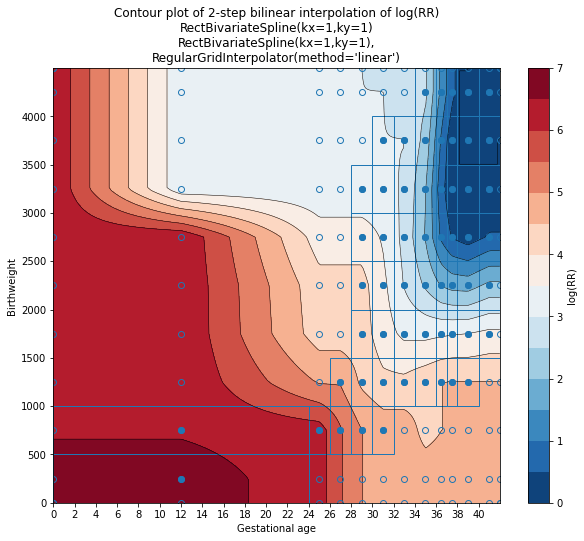

In [79]:
age=2
sex=2
lbwsg_plots.single_log_rr_plot(
    gai,
    bwi,
    np.log(rri_by_age_sex[(age, sex)]),
    cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bilinear',
    subtitle="RectBivariateSpline(kx=1,ky=1)"
    "\nRectBivariateSpline(kx=1,ky=1),"
    "\nRegularGridInterpolator(method='linear')",
    draw_category_rectangles=True,
    draw_grid_midpoints=True,
    draw_grid_boundary_points=True,
);

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


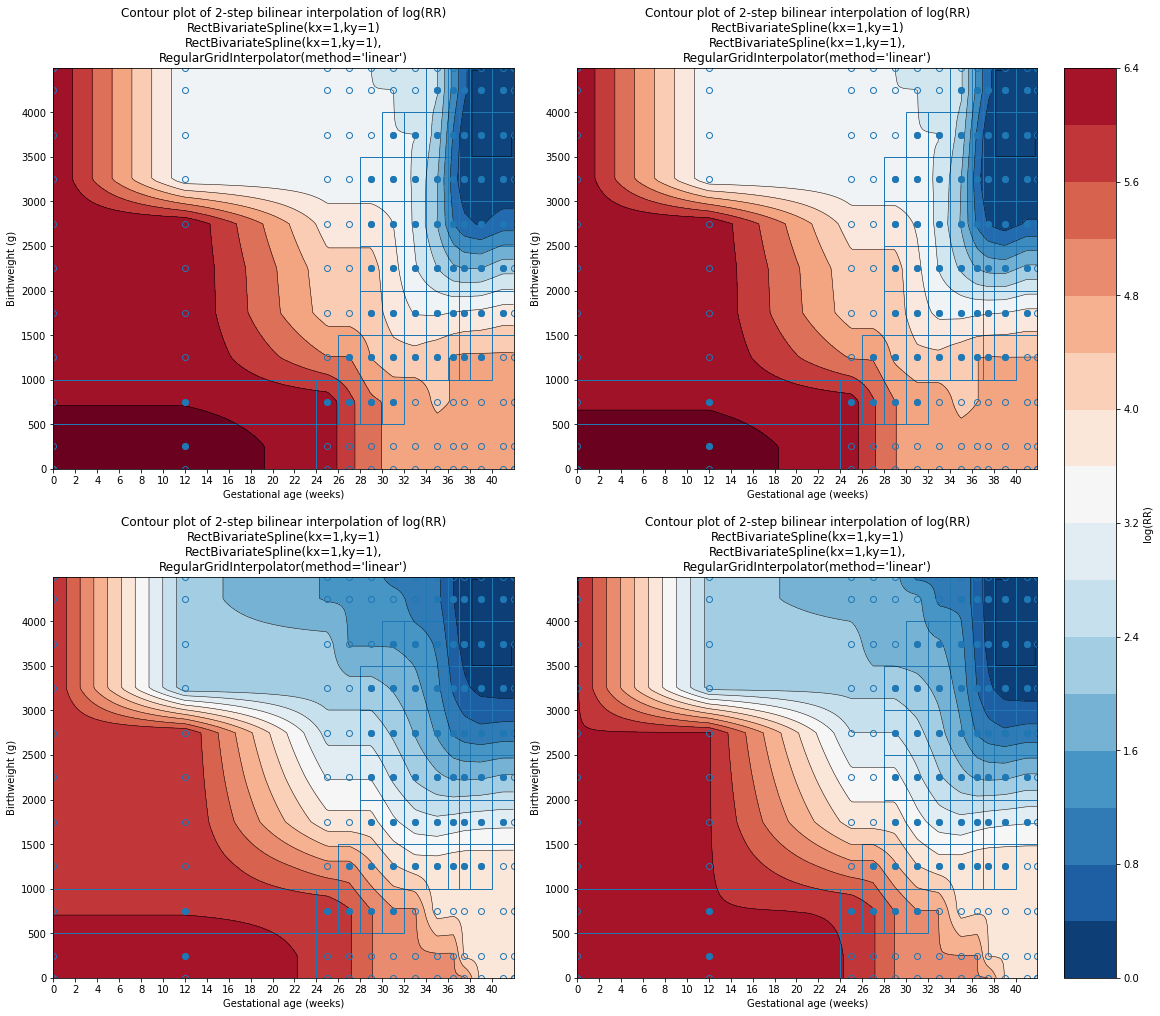

In [104]:
lbwsg_plots.plot_log_rrs_by_age_sex(
    gai,
    bwi,
    {age_sex: np.log(rri_by_age_sex[(age_sex)]) for age_sex in rri_by_age_sex},
    cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bilinear',
    subtitle="RectBivariateSpline(kx=1,ky=1)"
    "\nRectBivariateSpline(kx=1,ky=1),"
    "\nRegularGridInterpolator(method='linear')",
    draw_category_rectangles=True,
    draw_grid_midpoints=True,
    draw_grid_boundary_points=True,
);

In [83]:
[age_sex for age_sex in rri_by_age_sex]

[(2, 1), (2, 2), (3, 1), (3, 2)]

In [101]:
vmax = 0
for logrri in logrri_by_age_sex.values():
    vmax = new_max if (new_max := logrri.max()) > vmax else vmax
vmax

6.777389968163108

In [55]:
np.asarray(1).reshape(1,)

array([1])

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


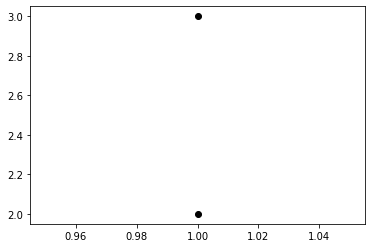

In [58]:
plt.plot(np.asarray(1).reshape(1,),[[2,3]], 'o', color='k')

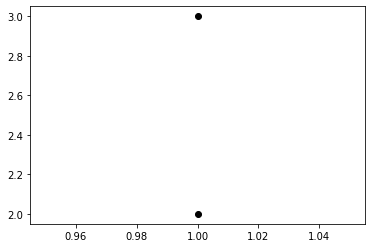

In [70]:
plt.plot(1,[[2,3]], 'o', color='k')

In [74]:
np.array([2,3])[None,:]

array([[2, 3]])

In [81]:
a = np.array([[1,2], [3,4]])
a

array([[1, 2],
       [3, 4]])

In [82]:
a[0,0]

1

In [86]:
x,y = interval_data_by_cat[['ga_midpoint', 'bw_midpoint']]
print(x,y)

ga_midpoint bw_midpoint


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
for age_group, sex in log_rr_interpolators.index:
    print(age_group, sex)

2 1
2 2
3 1
3 2


In [64]:
log_rr

lbwsg_category           cat2      cat8     cat10     cat11     cat14  \
age_group_id sex_id                                                     
2            1       6.777390  6.473735  6.282088  5.639364  4.885137   
             2       6.753489  6.443570  6.233211  5.552179  4.794379   
3            1       6.266799  5.973104  5.928419  5.637784  4.851887   
             2       6.355469  6.032966  5.978840  5.637784  4.813699   

lbwsg_category          cat15     cat17     cat19     cat20     cat21  ...  \
age_group_id sex_id                                                    ...   
2            1       5.104010  5.014956  4.365138  4.276153  4.487390  ...   
             2       5.009480  4.957595  4.326600  4.250689  4.409759  ...   
3            1       5.220292  4.943672  3.814145  3.744651  4.472732  ...   
             2       5.184647  4.947133  3.837307  3.832136  4.462171  ...   

lbwsg_category          cat88     cat89     cat90     cat95     cat96  \
age_group_id sex_id                                                     
2            1       3.503088  3.236751  3.012311  2.945075  3.006384   
             2       3.448038  3.188899  3.012955  2.926752  3.012251   
3            1       2.340725  1.967573  1.567604  1.725889  1.461014   
             2       2.523545  2.138370  1.722663  1.905442  1.658838   

lbwsg_category         cat106    cat116    cat117    cat123    cat124  
age_group_id sex_id                                                    
2            1       4.544392  4.587557  3.622989  3.765708  4.586097  
             2       4.497236  4.516768  3.504378  3.636236  4.529665  
3            1       3.886377  3.893524  3.066983  3.089727  3.910083  
             2       3.945067  3.970970  3.127687  3.165575  3.973131  

[4 rows x 58 columns]

In [9]:
pd.Interval(cat_df.loc[0,'bw_interval'])

TypeError: __init__() takes at least 2 positional arguments (1 given)

In [78]:
mi, ma = interval_data_by_cat[['ga_start', 'ga_end']].agg({'ga_start': 'min', 'ga_end': 'max'})
print(mi, ma)

0 42


In [80]:
interval_data_by_cat[['ga_start', 'bw_start']].min()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ga_start    0
bw_start    0
dtype: int64

In [90]:
import re

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
cat_df['ga_interval']

0      [0, 24)
1      [0, 24)
2     [24, 26)
3     [26, 28)
4     [30, 32)
        ...   
53    [36, 37)
54    [38, 40)
55    [38, 40)
56    [40, 42)
57    [37, 38)
Name: ga_interval, Length: 58, dtype: object

In [92]:
interval1 = cat_df.at[57, 'ga_interval']
interval1

'[37, 38)'

In [95]:
re.findall(r'[\(\[]', interval1)

['[']

In [96]:
re.findall(r'[\)\]]', interval1)

[')']

In [103]:
pattern = r'(?P<left>[\(\[])'
re.findall(pattern, interval1)

['[']

In [104]:
pattern = r'(?P<left_delimiter>[\(\[])(?P<left>\d+), (?P<right>\d+)(?P<right_delimiter>[\)\]])'
re.findall(pattern, interval1)

[('[', '37', '38', ')')]

In [ ]:
pd.Interval()

In [126]:
pattern = r'(?P<left_delimiter>[\(\[])(?P<left>\d+), (?P<right>\d+)(?P<right_delimiter>[\)\]])'
# df = cat_df['ga_interval'].str.extract(pattern)
intervals = pd.Series(['[0, 4]', '(87, 245)', '(90, 235]', '[98, 348)'], name='interval')
df = intervals.str.extract(pattern)
df['left_closed'] = (df['left_delimiter'] == '[').astype(int)
df['right_closed'] = (df['right_delimiter'] == ']').astype(int)
df['closed'] = (df['left_closed']+2*df['right_closed']).map({0:'neither', 1:'left', 2:'right', 3:'both'})
df

,left_delimiter,left,right,right_delimiter,left_closed,right_closed,closed
0,[,0,4,],1,1,both
1,(,87,245,),0,0,neither
2,(,90,235,],0,1,right
3,[,98,348,),1,0,left


In [127]:
np.vectorize(pd.Interval)(df['left'].astype(int), df['right'].astype(int), df['closed'])

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([Interval(0, 4, closed='both'), Interval(87, 245, closed='neither'),
       Interval(90, 235, closed='right'),
       Interval(98, 348, closed='left')], dtype=object)

In [128]:
def string_to_interval(interval_strings: pd.Series) -> pd.Series:
    pattern = r'(?P<left_delimiter>[\(\[])(?P<left>\d+), (?P<right>\d+)(?P<right_delimiter>[\)\]])'
    df = interval_strings.str.extract(pattern)
    df['left_closed'] = (df['left_delimiter'] == '[').astype(int)
    df['right_closed'] = (df['right_delimiter'] == ']').astype(int)
    df['closed'] = (df['left_closed']+2*df['right_closed']).map({0:'neither', 1:'left', 2:'right', 3:'both'})
    intervals = np.vectorize(pd.Interval)(df['left'].astype(int), df['right'].astype(int), df['closed'])
    return pd.Series(intervals, index=interval_strings.index, name=interval_strings.name)

string_to_interval(intervals)

0       [0, 4]
1    (87, 245)
2    (90, 235]
3    [98, 348)
Name: interval, dtype: object

In [130]:
string_to_interval(cat_df['ga_interval'])

0      [0, 24)
1      [0, 24)
2     [24, 26)
3     [26, 28)
4     [30, 32)
        ...   
53    [36, 37)
54    [38, 40)
55    [38, 40)
56    [40, 42)
57    [37, 38)
Name: ga_interval, Length: 58, dtype: interval